In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

BIG_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 20

matplotlib.rc('axes', titlesize=BIGGEST_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=BIGGEST_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
data1 = np.load('./data_for_xi_calculation/dX_data_t=50_to_t=100_grid_64_c_1by64.npz')
data2 = np.load('./data_for_xi_calculation/dX_data_t=100_to_t=110_grid_64_c_1by64.npz')

In [4]:
# combining the data
dX1 = np.concatenate((data1['dX_x'], data2['dX_x']), axis=0)
dX2 = np.concatenate((data1['dX_y'], data2['dX_y']), axis=0)

In [5]:
dX1.shape, dX2.shape

((600, 49409), (600, 49409))

In [6]:
n_nodes = dX1.shape[1] # total no. of nodes
print(f'no. of nodes: {n_nodes}')

no. of nodes: 49409


In [7]:
dX = np.concatenate((dX1, dX2), axis=1)
dX.shape

(600, 98818)

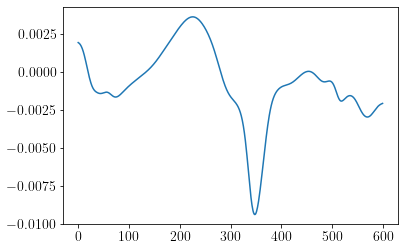

In [8]:
plt.plot(dX[:,0])

In [9]:
def acf(x,lags):
    '''manualy compute, non partial'''

    mean = np.mean(x)
    var = np.var(x)
    xp = x - mean
    corr = [1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

In [10]:
lag_vec = np.arange(300)
lag_vec.size

300

In [11]:
dX1_a = np.mean(dX1, axis=1)
dX1_a.shape

(600,)

In [12]:
dX2_a = np.mean(dX2, axis=1)
dX2_a.shape

(600,)

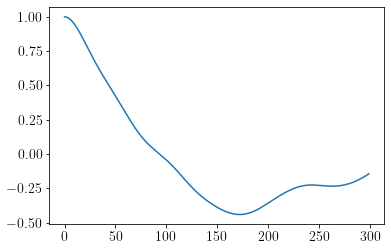

In [13]:
autocor = acf(dX1_a, lag_vec) # this is not a good measure of approximate ACF. Later i calculate it more accurately
plt.plot(autocor)

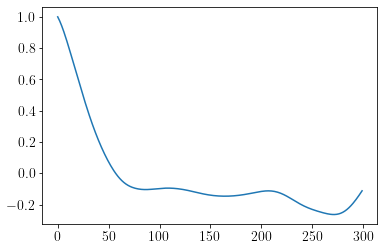

In [14]:
autocor = acf(dX2_a, lag_vec)
plt.plot(autocor)

In [15]:
autocor_mat_x = np.zeros(shape=(lag_vec.size, n_nodes)) # matrix containing ACF of all nodes for x-vel
autocor_mat_y = np.zeros(shape=(lag_vec.size, n_nodes))
for i in range(n_nodes):
    col_x = dX1[:,i]
    col_y = dX2[:,i]
    autocor_x = acf(col_x, lag_vec)
    autocor_y = acf(col_y, lag_vec)
    autocor_mat_x[:,i] = autocor_x
    autocor_mat_y[:,i] = autocor_y


In [16]:
autocor_mat_x.shape

(300, 49409)

In [17]:
mean_decor_x = np.mean(autocor_mat_x, axis=1) # taking the mean of autocor of all nodes (x vel)
mean_decor_y = np.mean(autocor_mat_y, axis=1) # taking the mean of autocor of all nodes (y vel)
autocor_mat_x.shape

(300, 49409)

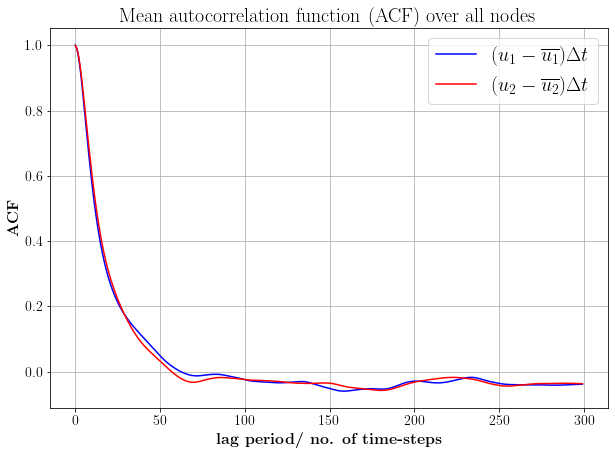

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(mean_decor_x, label=r'$(u_1 - \overline{u_1})\Delta t$', color='b')
ax.plot(mean_decor_y, label=r'$(u_2 - \overline{u_2})\Delta t$', color='red')
ax.legend()
ax.set_title(r'Mean autocorrelation function (ACF) over all nodes')
ax.grid(axis='both')
ax.set_xlabel(r'\bf{lag period/ no. of time-steps}')
ax.set_ylabel(r'\bf {ACF}')
plt.savefig('./plots/mean_acf_NS.pdf', bbox_inches='tight')


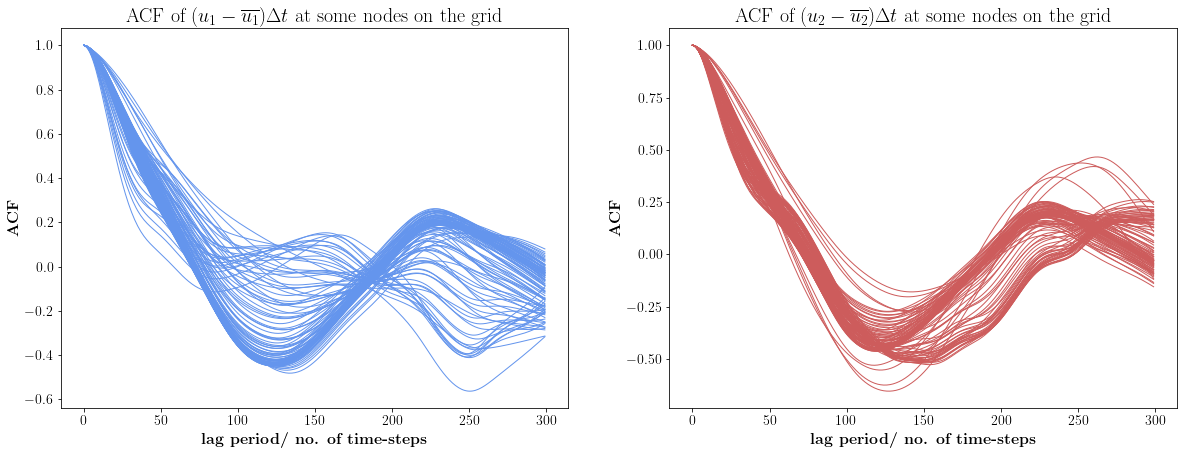

In [40]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
for i in range(100):
    col_x = dX1[:,i]
    autocor_x = acf(col_x, lag_vec)
    ax[0].plot(autocor_x, color='cornflowerblue', linewidth=1)
ax[0].set_ylabel(r'\textbf{ACF}')
ax[0].set_xlabel(r'\textbf{lag period/ no. of time-steps}')
ax[0].set_title(r'ACF of $({u_1} -\overline{u_1}) \Delta t$ at some nodes on the grid')
# use set_raterized to keep the transparency 
# ax[0].set_rasterized(True) # this works but the picture quality gets worse
# a work around is to use ligher colors

for i in range(100):
    col_y = dX2[:,i]
    autocor_y = acf(col_y, lag_vec)
    ax[1].plot(autocor_y, color='indianred', linewidth=1)
ax[1].set_ylabel(r'\textbf{ACF}')
ax[1].set_xlabel(r'\textbf{lag period/ no. of time-steps}')
ax[1].set_title(r'ACF of $({u_2} -\overline{u_2}) \Delta t$ at some nodes on the grid')
# ax[1].set_rasterized(True)
plt.savefig('./plots/acf_some_nodes_NS.pdf', bbox_inches='tight')

The above method of ACF estimation may not be correct. I should calculate the ACF of time-matrix obtained from SVD of $(u - \overline{u}) \Delta t$ data instead.

Do that and see if the results are different than the above approach !

In [21]:
# approx. decorrelation time ~ 50 Dt
t_decor = 50
dX = dX[np.ix_([i for i in np.arange(0,dX.shape[0],t_decor)])] # new dX containing only decorrelated data

-0.0006923006191946506

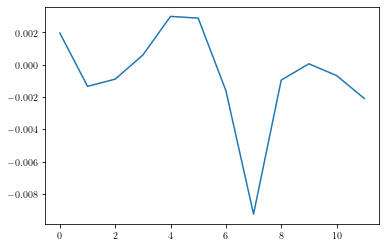

In [65]:
plt.plot(dX[:,0])
np.mean(dX[:,0])

In [27]:
dX.shape

(12, 98818)

In [28]:
m = dX.shape[0]
print(m)

12


In [29]:
from numpy import linalg as LA
from scipy import signal

In [30]:
Dt_c = 0.1
scaled_dX = dX*np.sqrt(Dt_c)

In [38]:
F = signal.detrend(scaled_dX, axis=0, type='constant') # i calculated the eigenvalues without centering also.
# i observed that the difference was not that much. first b**2/(m-1) value was close to 0.02
F.shape

(12, 98818)

In [39]:
A, b, CT = LA.svd(F, full_matrices=False)

In [41]:
b**2/(m-1)

array([1.96135612e-02, 1.27059395e-02, 1.10264986e-02, 9.98323385e-03,
       8.98368664e-03, 8.27905635e-03, 7.48838242e-03, 7.05155567e-03,
       6.64397339e-03, 6.19382801e-03, 5.68500989e-03, 1.88593913e-33])

In [42]:
B = np.diag(b/np.sqrt(m-1))
B.shape, CT.shape

((12, 12), (12, 98818))

In [43]:
BCT = np.matmul(B, CT)

In [45]:
var_vec = b**2/(m-1)

In [47]:
n_eigval = 11

p1 = 100*np.sum(var_vec[:n_eigval])/(np.sum(var_vec))

print(f'Total vairance captured by first {n_eigval} eigenvalues: {p1}')

Total vairance captured by first 11 eigenvalues: 100.0


In [52]:
n_eigval = 9

p1 = 100*np.sum(var_vec[:n_eigval])/(np.sum(var_vec))

print(f'Total vairance captured by first {n_eigval} eigenvalues: {p1}')

Total vairance captured by first 9 eigenvalues: 88.53999387241676


In [55]:
n_eigval = 6

p1 = 100*np.sum(var_vec[:n_eigval])/(np.sum(var_vec))

print(f'Total vairance captured by first {n_eigval} eigenvalues: {p1}')

Total vairance captured by first 6 eigenvalues: 68.10299848637452


Text(10, 5, '9')

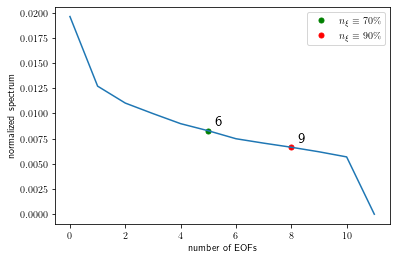

In [56]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
fig, ax = plt.subplots()
# ax.plot(6,var_vec[6], 'bo', ms=5, label=r'$n_{\xi} \equiv 50 \%$')
ax.plot(5,var_vec[5], 'go', ms=5, label=r'$n_{\xi} \equiv 70 \%$')
ax.plot(8,var_vec[8], 'ro', ms=5, label=r'$n_{\xi} \equiv 90 \%$')
ax.plot(np.arange(var_vec.size),var_vec)
ax.legend(loc = "upper right")
ax.set_xlabel(r"number of EOFs")
ax.set_ylabel(r"normalized spectrum")
ax.annotate(f"{6}", (5, var_vec[5]), fontsize= 15, textcoords="offset points", xytext=(10,5), ha= 'center')
ax.annotate(f"{9}", (8, var_vec[8]), fontsize= 15, textcoords="offset points", xytext=(10,5), ha= 'center')

In [57]:
combined_vec = BCT
detached_vec = np.zeros((combined_vec.shape[0],int(combined_vec.shape[1]/2),2))
for i in range(combined_vec.shape[0]):
    detached_vec[i,:,0] = combined_vec[i,:int(combined_vec.shape[1]/2)]
    detached_vec[i,:,1] = combined_vec[i,int(combined_vec.shape[1]/2):]
    
combined_vec.shape, detached_vec.shape

((12, 98818), (12, 49409, 2))

In [58]:
xi_mat = detached_vec

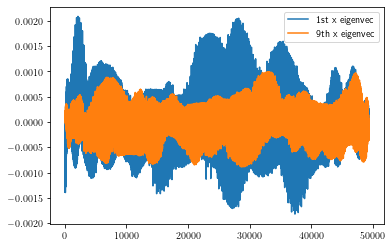

In [59]:
plt.plot(xi_mat[0,:,0], label='1st x eigenvec'), plt.plot(xi_mat[8,:,0], label='9th x eigenvec')
plt.legend()

In [60]:
eig_vec = xi_mat[:11,:,:]
eig_vec.shape

(11, 49409, 2)

In [62]:
# data_file = './calculated_xi_vectors/xi_matrix_11_eigvec_c_1_by_64_decor_t_50_Dt_t=50_to_t=110.npz'

# np.savez(data_file, xi_mat = eig_vec)